In [89]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, r2_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


In [90]:
df = pd.read_csv(r'C:\Users\DAI.STUDENTSDC\Desktop\Machine Learning\Data Sets\Cases\human-resources-analytics\HR_comma_sep.csv')
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.10,0.77,6,247,4,0,1,0,sales,low
3,0.92,0.85,5,259,5,0,1,0,sales,low
4,0.89,1.00,5,224,5,0,1,0,sales,low


In [91]:
X = df.drop(columns=['salary'], axis=1)
y = df['salary']

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24, stratify=y)

Hyorerparameter Tuning using GridSearchCV



In [ ]:
ohe = OneHotEncoder(
    sparse_output=False, 
    drop='first'
).set_output(transform='pandas')


ct =make_column_transformer(
    ('passthrough', make_column_selector(dtype_exclude=[
        'object',
        'category',
    ])),
    (ohe, make_column_selector(dtype_include=[
        'object',
        'category',
    ])),
    verbose_feature_names_out=False,
).set_output(transform='pandas')


dtc = DecisionTreeClassifier(random_state=24)


pipe = Pipeline([
    ('preprocessor', ct),
    ('classifier', dtc),
])



kfold = StratifiedKFold(n_splits=5, random_state=24, shuffle=True)

params = { 
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__max_depth': list([None, 2, 3, 4, 5, 6]),
    'classifier__min_samples_leaf' : np.arange(1, 51, 5),
    'classifier__min_samples_split': np.arange(2, 51, 5),
}


gcv = GridSearchCV(
    estimator=pipe,
    param_grid=params,
    cv=kfold,
    scoring='roc_auc_ovo',
    verbose=True,
)


In [94]:
gcv.fit(X_train, y_train)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


c:\Users\DAI.STUDENTSDC\.conda\envs\pythonProject\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=24, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('passthrough',
                                                                         'passthrough',
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000216B9F10860>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         <sklearn.compose._colum...tor object at 0x00000216B73FF380>)],
                                                          verbose_feature_names_out=False)),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=24))]),
             param_grid={'classifier__max_depth': [None, 2, 3, 4, 5, 6],
                         'classifier__min_samples_leaf': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46]),
                         'classifier__min_samples_split': array([ 2,  7, 12, 17, 22, 27, 32, 37, 42, 47])},
             scoring='roc_auc_ovo', verbose=True)

In [95]:
print(gcv.best_score_)
print(gcv.best_params_)

0.6229786121276899
{'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}


In [96]:
best_dtc = gcv.best_estimator_

y_pred = gcv.best_estimator_.predict(X_test) 

print(accuracy_score(y_test, y_pred)) 

0.5692376083574128


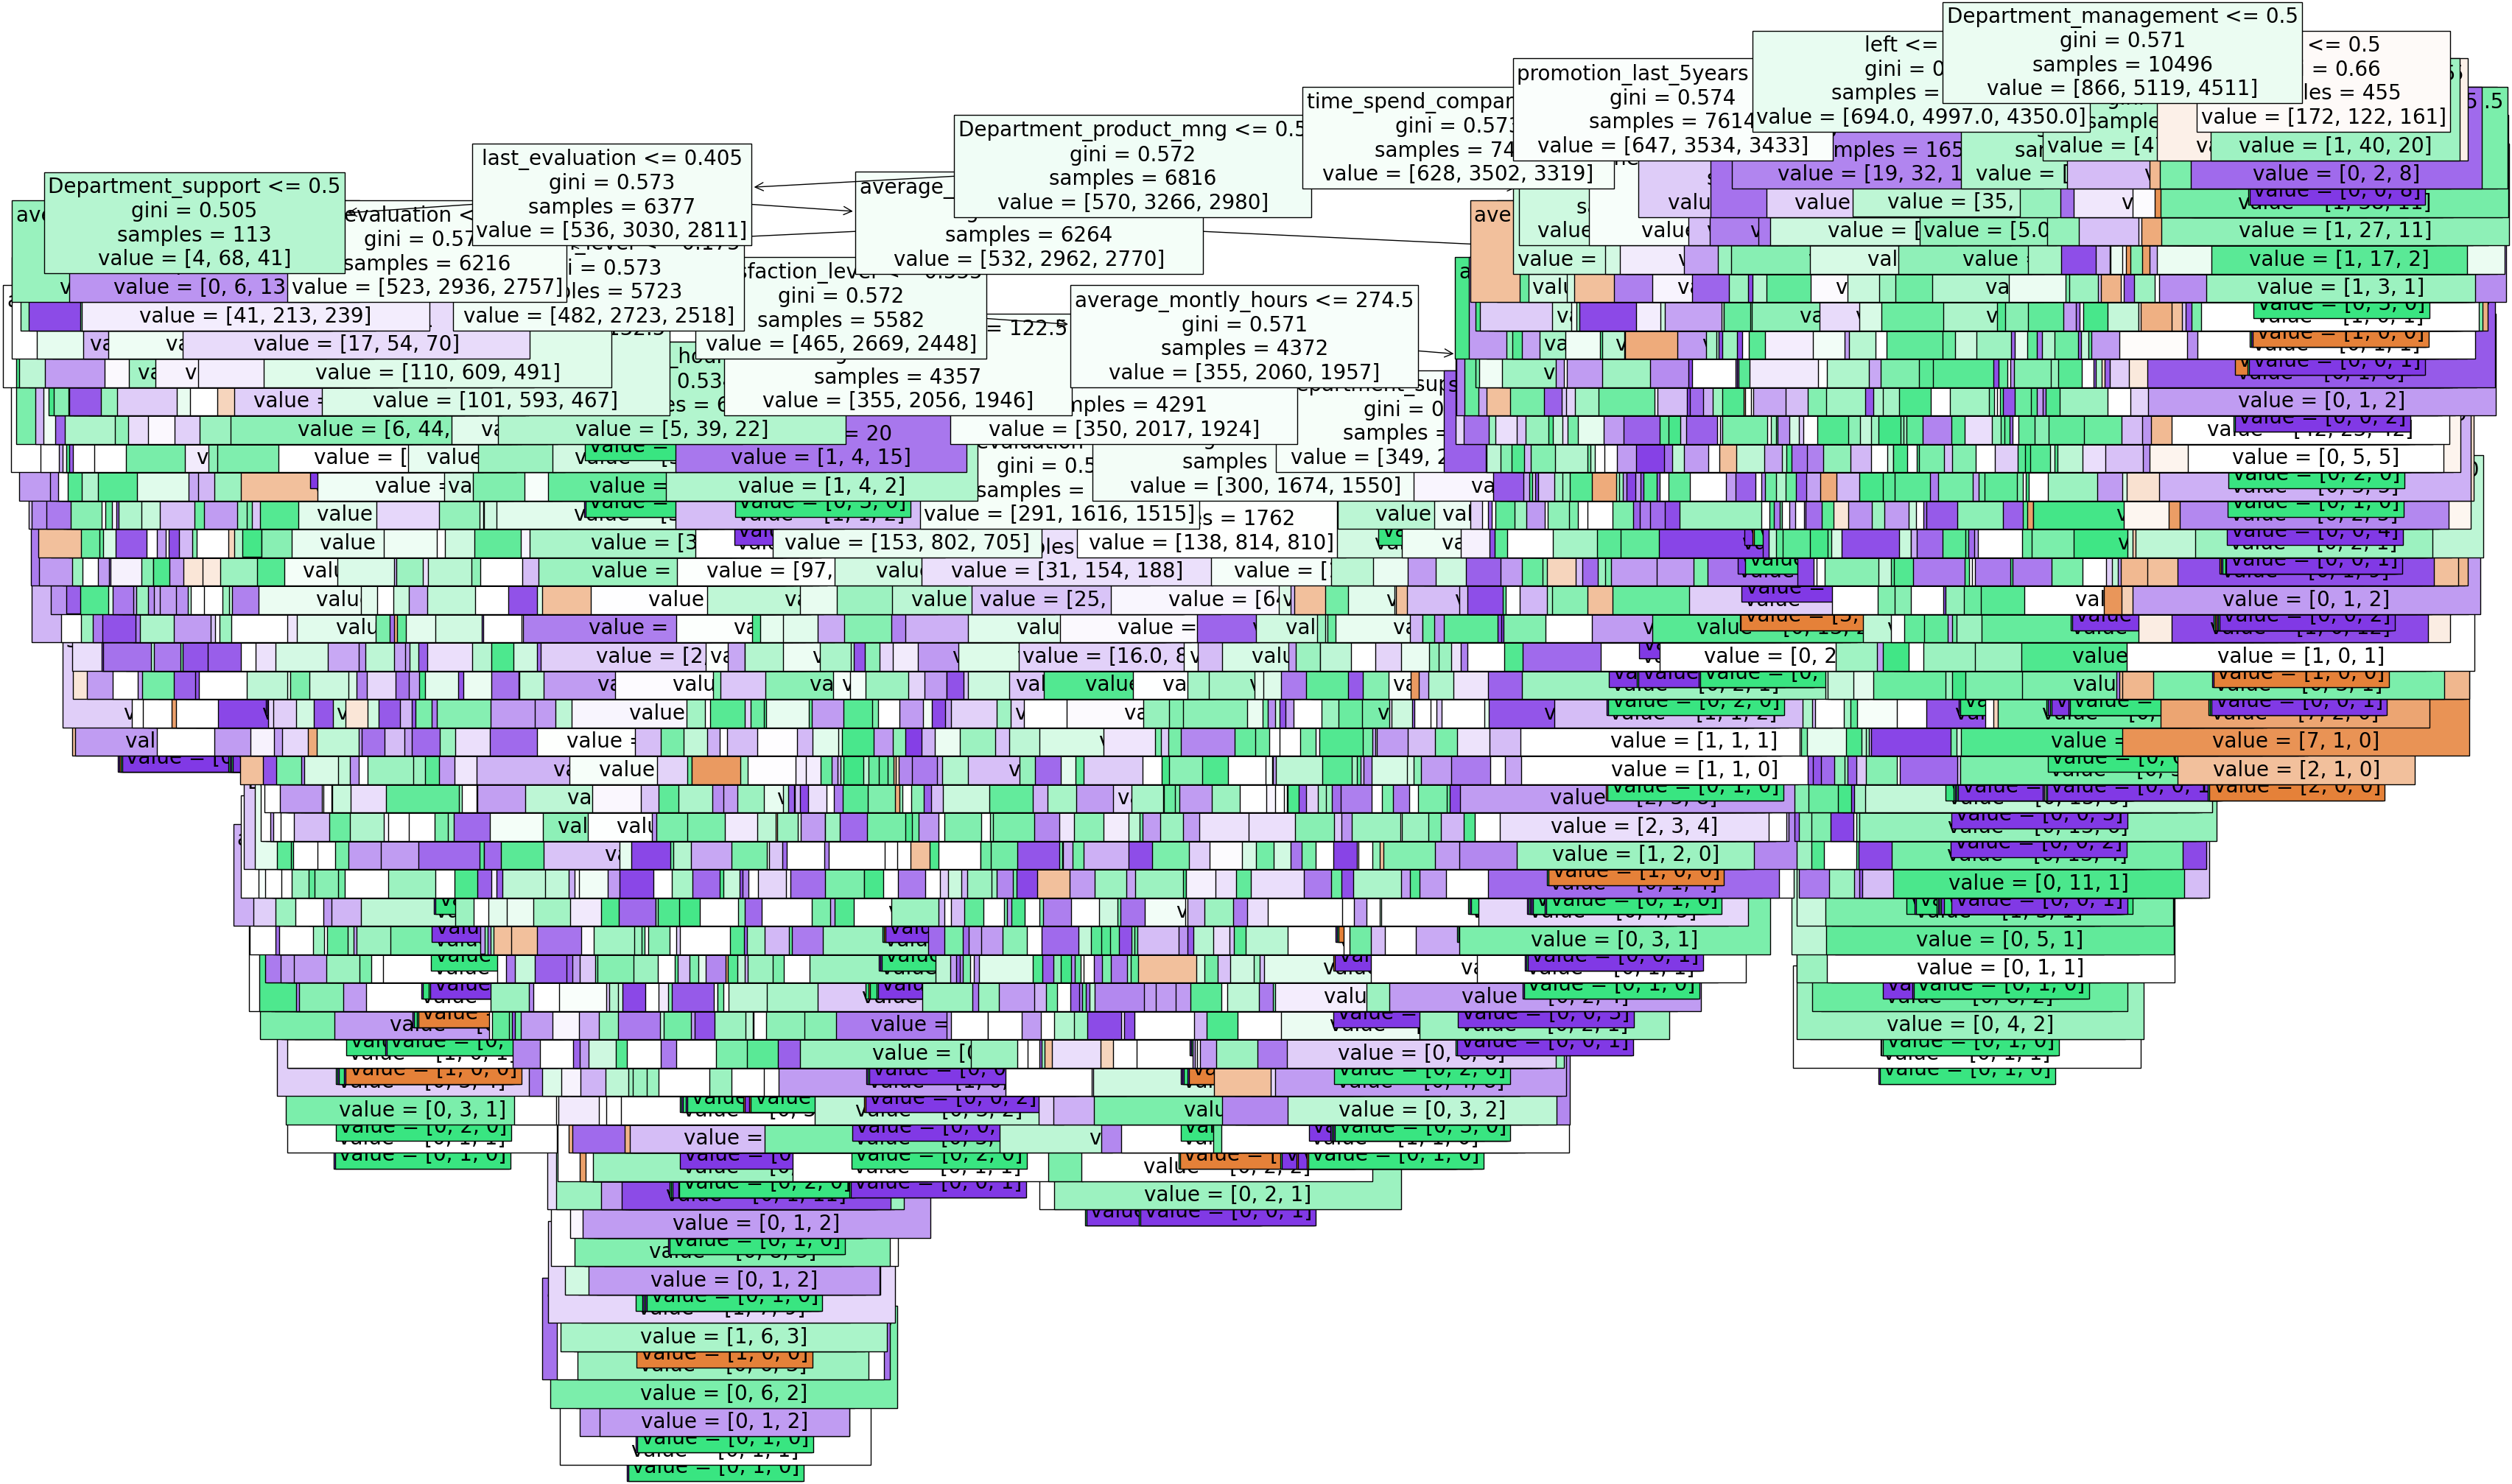

In [97]:
feature_names = gcv.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

plt.figure(figsize=(38, 25))
plot_tree(gcv.best_estimator_.named_steps['classifier'], feature_names=feature_names, filled=True, fontsize=20)
plt.show()


In [98]:
df_imp = pd.DataFrame({
    'features': list(gcv.best_estimator_.named_steps['preprocessor'].get_feature_names_out()),
    'importance': gcv.best_estimator_.named_steps['classifier'].feature_importances_
})

df_imp

,features,importance
0,satisfaction_level,0.212066
1,last_evaluation,0.206836
2,number_project,0.074540
3,average_montly_hours,0.275018
4,time_spend_company,0.068060
5,Work_accident,0.022094
6,left,0.012198
7,promotion_last_5years,0.004902
8,Department_RandD,0.011176
9,Department_accounting,0.014941


In [99]:
df_imp.sort_values('importance', inplace=True)
df_imp

,features,importance
7,promotion_last_5years,0.004902
15,Department_support,0.007156
13,Department_product_mng,0.008048
8,Department_RandD,0.011176
11,Department_management,0.011236
6,left,0.012198
10,Department_hr,0.013200
9,Department_accounting,0.014941
12,Department_marketing,0.017102
16,Department_technical,0.019226


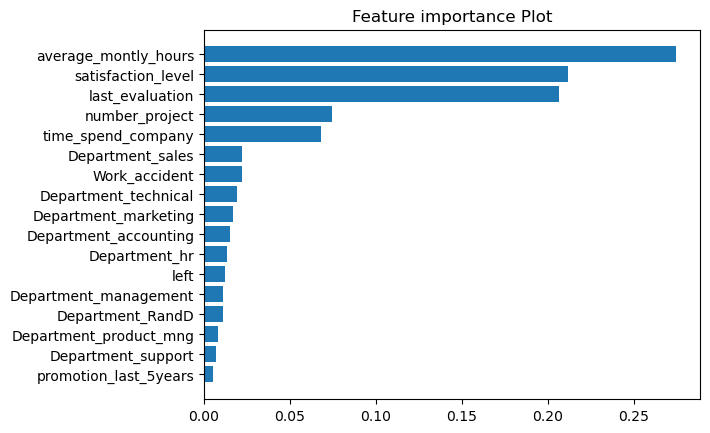

In [100]:
plt.barh(df_imp['features'], df_imp['importance'])
plt.title('Feature importance Plot')
plt.show()